In [ ]:
import numpy as np
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
import webrtcvad
from pydub import AudioSegment
from datetime import datetime, timezone

from utils.process_muac import list_years, list_months, list_days, list_audio_one_day, build_audio_catalog

base_dir = "/store/kruu/atc_muac/"

TO DO: 
- Implement diarization on top on vad for each ATC communication
- Test models from TU Delft for transcription: 
    - https://repository.tudelft.nl/record/uuid:8e02d222-5775-441d-94d2-96c26156cf43
    - https://github.com/jlvdoorn/
    - https://huggingface.co/jlvdoorn
- Implement timestamping using mp3 name (maybe in catalog ?)
- Modify pipeline to download ADS-B data for the MUAC Delta sector (find bounds)
- Modify pipeline to transcript everything directly. 

In [ ]:
# --- Quick test ---

# 1) Discover structure
print(list_years(base_dir))              # ['2024', '2025', ...]
print(list_months(base_dir, '2025'))       # ['07', '08', ...] (depends on your layout)
print(list_days(base_dir, '2025','08'))    # ['23', '29', ...]


# 2) List audio for a date
audio_list = list_audio_one_day(base_dir, '2025', '08', '09')
for a in audio_list:
    print(a["name"])

In [ ]:
# --- Load audio ---

start = datetime(2025, 8, 9, 10, 0, 0, tzinfo=timezone.utc)
stop  = datetime(2025, 8, 9, 10, 30, 0, tzinfo=timezone.utc)

catalog = build_audio_catalog(
    base_dir,
    ("2025","08","09"),
    sectors=["muac_delta_middle"],
    start=start, 
    stop=stop,
    max_workers=128,         
    show_progress=True,  
)
print(len(catalog), "files downloaded")

Loading audio: 100%|██████████| 73/73 [00:00<00:00, 333.91file/s]

73 files downloaded


In [33]:
def vad_split_segments(audio, frame_duration_ms=30, aggressiveness=2, min_speech_ms=300):
    # Load and convert audio - ensure 16 kHz mono for VAD
    audio = audio.set_channels(1).set_frame_rate(16000)
    samples = np.array(audio.get_array_of_samples()).astype(np.int16)
    sample_rate = 16000
    bytes_per_sample = 2

    # Frame configuration
    frame_size = int(sample_rate * frame_duration_ms / 1000)
    vad = webrtcvad.Vad(aggressiveness)

    speech_segments = []
    current_chunk = b''
    start_time = None
    times = []

    for i in range(0, len(samples) - frame_size, frame_size):
        frame = samples[i:i+frame_size]
        frame_bytes = frame.tobytes()

        is_speech = vad.is_speech(frame_bytes, sample_rate)
        timestamp = i / sample_rate

        if is_speech:
            if start_time is None:
                start_time = timestamp
            current_chunk += frame_bytes
        else:
            if current_chunk:
                duration = len(current_chunk) / (sample_rate * bytes_per_sample)
                if duration * 1000 >= min_speech_ms:
                    end_time = timestamp
                    chunk_audio = AudioSegment(
                        data=current_chunk,
                        sample_width=bytes_per_sample,
                        frame_rate=sample_rate,
                        channels=1,
                    )
                    speech_segments.append((start_time, end_time, chunk_audio))
                    times.append((start_time, end_time))
                current_chunk = b''
                start_time = None

    # Handle last chunk
    if current_chunk and start_time is not None:
        end_time = len(samples) / sample_rate
        chunk_audio = AudioSegment(
            data=current_chunk,
            sample_width=bytes_per_sample,
            frame_rate=sample_rate,
            channels=1,
        )
        speech_segments.append((start_time, end_time, chunk_audio))
        times.append((start_time, end_time))

    return speech_segments

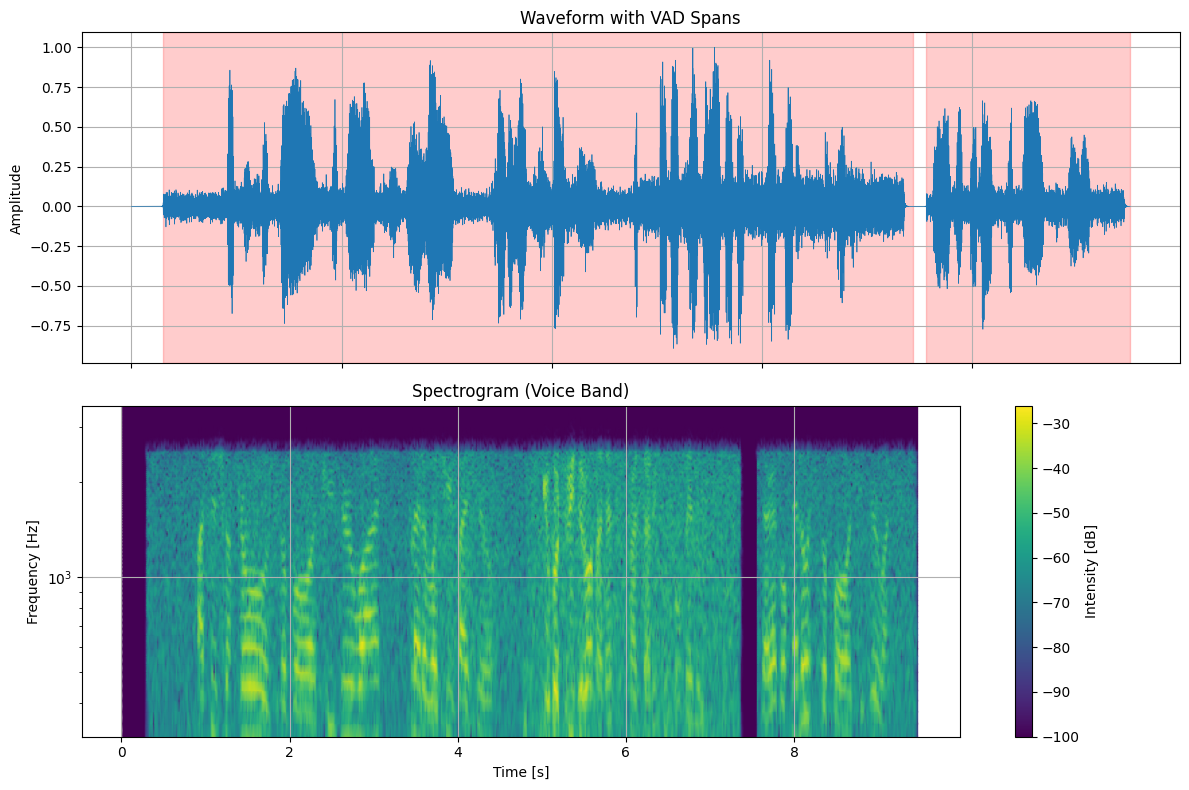

In [34]:
idx = np.random.randint(low=0, high=len(catalog))
test_audio = catalog[idx][1]
sample_rate = test_audio.frame_rate

# --- VAD ---
speech_segments = vad_split_segments(
    test_audio,
    frame_duration_ms=30,   # 10/20/30 ms
    aggressiveness=2,       # 0..3 
    min_speech_ms=300       
)
speech_regions = [(s, e) for (s, e, _) in speech_segments]

# --- build samples array for plots ---
samples = np.array(test_audio.get_array_of_samples()).astype(np.float32)
# normalize for display
peak = np.max(np.abs(samples)) or 1.0
samples = samples / peak
duration = len(samples) / sample_rate

# --- spectrogram (voice band only) ---
voice_band = (300, 3500)
log_freq = True

freqs, times, Sxx = spectrogram(samples, fs=sample_rate, nperseg=512, noverlap=256)
mask = (freqs >= voice_band[0]) & (freqs <= voice_band[1])
freqs_v = freqs[mask]
Sxx_v = Sxx[mask]

# --- plotting ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# waveform
time_axis = np.linspace(0, duration, len(samples))
ax1.plot(time_axis, samples, linewidth=0.5)
ax1.set_title("Waveform with VAD Spans")
ax1.set_ylabel("Amplitude")
ax1.grid(True)

for start, end in speech_regions:
    ax1.axvspan(start, end, color='red', alpha=0.2)

# spectrogram
pcm = ax2.pcolormesh(times, freqs_v, 10*np.log10(Sxx_v + 1e-10), shading="gouraud")
ax2.set_title("Spectrogram (Voice Band)")
ax2.set_ylabel("Frequency [Hz]")
ax2.set_xlabel("Time [s]")
if log_freq:
    ax2.set_yscale("log")
fig.colorbar(pcm, ax=ax2, label="Intensity [dB]")
ax2.grid(True)

# optional: highlight VAD spans on spectrogram too
# for start, end in speech_regions:
#     ax2.axvspan(start, end, color='red', alpha=0.15)

plt.tight_layout()
plt.show()

In [35]:
test_audio

In [36]:
from transformers import WhisperForConditionalGeneration, WhisperProcessor
from datetime import timedelta
import torch
import numpy as np

def audiosegment_to_tensor(audio):
    """Convert pydub.AudioSegment to torch.Tensor and sample rate."""
    samples = np.array(audio.get_array_of_samples()).astype(np.float32)
    samples /= 32768.0  # normalize to [-1, 1]
    waveform = torch.from_numpy(samples).unsqueeze(0)  # shape [1, num_samples]
    return waveform, audio.frame_rate

def transcribe_segments(speech_segments, model_name="jacktol/whisper-medium.en-fine-tuned-for-ATC"):
    model = WhisperForConditionalGeneration.from_pretrained(model_name)
    processor = WhisperProcessor.from_pretrained(model_name)
    model.eval()

    transcripts = []

    for i, (start, end, audio_segment) in enumerate(speech_segments):
        # Convert audio to tensor
        waveform, sr = audiosegment_to_tensor(audio_segment)
        inputs = processor(waveform.squeeze(), sampling_rate=sr, return_tensors="pt")
        input_features = inputs.input_features
        attention_mask = inputs.get("attention_mask", None)

        # Transcribe
        with torch.no_grad():
            generated_ids = model.generate(input_features, attention_mask=attention_mask)
        transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        transcripts.append(transcription)

        print(f"[{i+1}/{len(speech_segments)}] {transcription}")

    return transcripts

In [37]:
results = transcribe_segments(speech_segments)

[1/2] parture control is squawk three zero one flight level three five zero three zero one and then climbing to romeo
[2/2] direct omelo squawk one three zero one


In [31]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("Jzuluaga/bert-base-ner-atc-en-atco2-1h")
model = AutoModelForTokenClassification.from_pretrained("Jzuluaga/bert-base-ner-atc-en-atco2-1h")

In [39]:
from transformers import pipeline

nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="first")
for text in results:
    print(nlp(text))

Device set to use cpu


[{'entity_group': 'value', 'score': np.float32(0.838069), 'word': 'is', 'start': 16, 'end': 18}, {'entity_group': 'command', 'score': np.float32(0.8647319), 'word': 'squawk', 'start': 19, 'end': 25}, {'entity_group': 'value', 'score': np.float32(0.9997225), 'word': 'three zero one', 'start': 26, 'end': 40}, {'entity_group': 'value', 'score': np.float32(0.99988186), 'word': 'flight level three five zero three zero one', 'start': 41, 'end': 84}, {'entity_group': 'command', 'score': np.float32(0.99984014), 'word': 'and then climbing to', 'start': 85, 'end': 105}, {'entity_group': 'value', 'score': np.float32(0.99895704), 'word': 'romeo', 'start': 106, 'end': 111}]
[{'entity_group': 'command', 'score': np.float32(0.9765553), 'word': 'direct', 'start': 0, 'end': 6}, {'entity_group': 'callsign', 'score': np.float32(0.5976425), 'word': 'omelo', 'start': 7, 'end': 12}, {'entity_group': 'value', 'score': np.float32(0.99989855), 'word': 'one three zero one', 'start': 20, 'end': 38}]
